# Training Vision Models in PyTorch

In this exercise, we'll learn to train vision models in PyTorch. The steps involved will be similar to [Classification](./Classification.ipynb) notebook. However, we'll work with image datasets in this notebook. Here is a summary of what follow:
- [Data Preparation](#data-preparation)
- [Baseline Model](#baseline-model)
- [Training Baseline Model](#training-baseline-model)
- [Evaluation and Making Predictions With Baseline Model](#evaluate-baseline-model)
- [Model With Non-Linearity](#model-with-non-linearity)
- [Evaluation and Making Predictions With The Model With Non-Linearity](#evaluate-model-with-non-linearity)
- [CNN Model](#cnn-model)
- [Evaluation and Making Predictions With The CNN Model](#evaluate-the-cnn-model)
- [Compare Models](#compare-model-results-and-training-times)
- [Make Confusion Matrix for Performance Evaluation](#make-confusion-matrix-for-performance-evaluation)
- [Saving and Loading Models](#saving-and-loading-the-best-performing-model)

We'll follow the [PyTorch Computer Vision](https://www.learnpytorch.io/03_pytorch_computer_vision/) tutorial by [@mrdbourke](https://github.com/mrdbourke/pytorch-deep-learning)

# Import Modules

In [200]:
import random
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
import pandas as pd
import matplotlib.pyplot as plt

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from pathlib import Path
from timeit import default_timer as timer
from tqdm.auto import tqdm

print(f'Torch Version: {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')

Torch Version: 2.1.0.dev20230608
Torchvision Version: 0.16.0.dev20230608


# Data Preparation

We'll work with [FasionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset for this exercise. It is a collection of 10 different kinds of clothing.

## Download

In [201]:
ROOT = '~/torchvision-datasets/'
IMG_SIZE = 28

train_data = datasets.FashionMNIST(
    root=ROOT,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root=ROOT,
    train=False,
    download=True,
    transform=ToTensor()
)

# Training Set
image, label = train_data[0]
_, dim_1, _ = image.shape
index_1_0, index_1_1 = random.randint(0, dim_1 - 1), random.randint(0, dim_1 - 1)

print('Dataset Sizes')
print('--------------')
print(f'Training Set Size: {len(train_data)}')
print(f'Test Set Size: {len(test_data)}')

print('\nTraining Set')
print('------------')
print(f'image.shape: {image.shape}')
print(f'Sample Indices: {index_1_0} and {index_1_1}')
print(f'image[0, {index_1_0}]: {image[0, index_1_0]}')
print(f'image[0, {index_1_1}]: {image[0, index_1_1]}')
print(f'label: {label}')

# Test Set
image, label = train_data[0]
_, dim_1, _ = image.shape
index_1_0, index_1_1 = random.randint(0, dim_1 - 1), random.randint(0, dim_1 - 1)

print('\nTest Set')
print('------------')
print(f'image.shape: {image.shape}')
print(f'Sample Indices: {index_1_0} and {index_1_1}')
print(f'image[0, {index_1_0}]: {image[0, index_1_0]}')
print(f'image[0, {index_1_1}]: {image[0, index_1_1]}')
print(f'label: {label}')

Dataset Sizes
--------------
Training Set Size: 60000
Test Set Size: 10000

Training Set
------------
image.shape: torch.Size([1, 28, 28])
Sample Indices: 16 and 15
image[0, 16]: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0706, 0.1725, 0.3216, 0.4196, 0.7412,
        0.8941, 0.8627, 0.8706, 0.8510, 0.8863, 0.7843, 0.8039, 0.8275, 0.9020,
        0.8784, 0.9176, 0.6902, 0.7373, 0.9804, 0.9725, 0.9137, 0.9333, 0.8431,
        0.0000])
image[0, 15]: tensor([0.0000, 0.0118, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2431, 0.5686, 0.8000, 0.8941, 0.8118, 0.8353, 0.8667, 0.8549, 0.8157,
        0.8275, 0.8549, 0.8784, 0.8745, 0.8588, 0.8431, 0.8784, 0.9569, 0.6235,
        0.0000])
label: 9

Test Set
------------
image.shape: torch.Size([1, 28, 28])
Sample Indices: 23 and 14
image[0, 23]: tensor([0.0000, 0.0000, 0.2902, 0.7412, 0.8314, 0.7490, 0.6863, 0.6745, 0.6863,
        0.7098, 0.7255, 0.7373, 0.7412, 0.7373, 0.7569, 0.7765, 0.8000, 0.8196,
        0.8235, 0.8235, 

## Exploration

In [202]:
labels = pd.DataFrame({
    "label": train_data.targets
})

print('Classes')
print('--------')
print(f'{train_data.classes}')

print('\nLabels')
display(labels.head(10))

print('\nLabel Counts')
print('------------')
display(labels.label.value_counts())


Classes
--------
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Labels


,label
0,9
1,0
2,0
3,3
4,0
5,2
6,7
7,2
8,5
9,5



Label Counts
------------


label
9    6000
0    6000
3    6000
2    6000
7    6000
5    6000
1    6000
6    6000
4    6000
8    6000
Name: count, dtype: int64

## Visualization

### Single Input

Text(0.5, 1.0, 'Coat [4]')

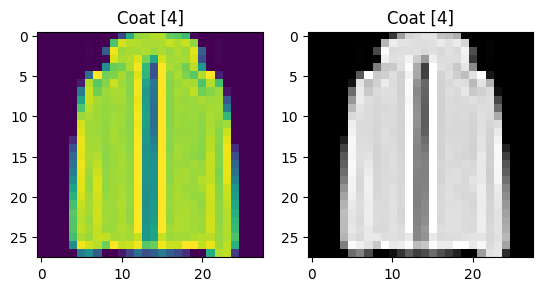

In [203]:
item_id = random.randint(0, len(train_data) - 1)
image, label = train_data[item_id]

plt.subplot(1, 2, 1)
plt.imshow(image.squeeze())
plt.title(f'{train_data.classes[label]} [{label}]')

plt.subplot(1, 2, 2)
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'{train_data.classes[label]} [{label}]')

### Multiple Inputs

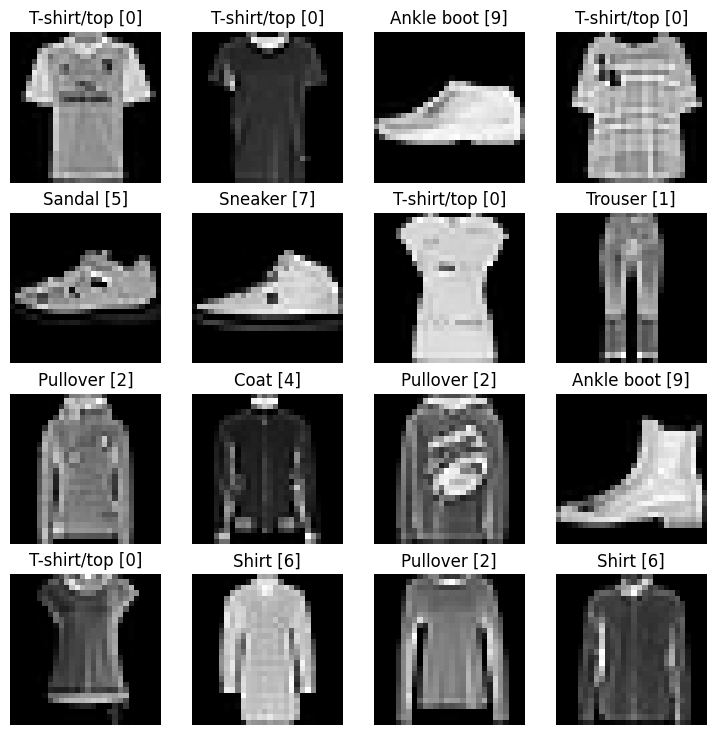

In [204]:
SEED = 3

torch.manual_seed(3)

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for idx in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]

    fig.add_subplot(rows, cols, idx)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f'{train_data.classes[label]} [{label}]')
    plt.axis(False)

## DataLoader

Data Loaders
-------------
Training DataLoader: 1875 batches of size 32
Test DataLoader: 313 batches of size 32

Training Batch Shape:: Images: torch.Size([32, 1, 28, 28]) Labels: torch.Size([32])
Test Batch Shape:: Images: torch.Size([32, 1, 28, 28]) Labels: torch.Size([32])
Image size: torch.Size([1, 28, 28])
Label: 8, label size: torch.Size([])


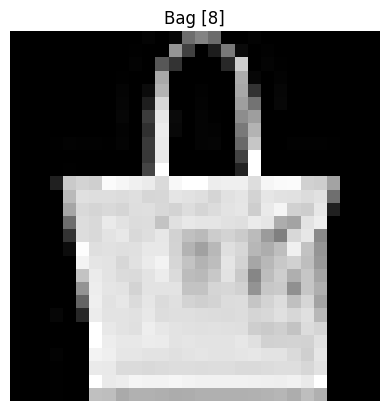

In [205]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
    batch_size=BATCH_SIZE,
    shuffle=True 
)

test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

print('Data Loaders')
print('-------------')
print(f"Training DataLoader: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Test DataLoader: {len(test_dataloader)} batches of size {BATCH_SIZE}")


train_images_batch, train_labels_batch = next(iter(train_dataloader))
test_images_batch, test_labels_batch = next(iter(test_dataloader))

print(f'\nTraining Batch Shape:: Images: {train_images_batch.shape} Labels: {train_labels_batch.shape}')
print(f'Test Batch Shape:: Images: {test_images_batch.shape} Labels: {test_labels_batch.shape}')

torch.manual_seed(SEED)

random_idx = torch.randint(0, len(train_images_batch), size=[1]).item()
image, label = train_images_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(image.squeeze(), cmap="gray")
plt.title(f'{train_data.classes[label]} [{label}]')
plt.axis('off')

print(f"Image size: {image.shape}")
print(f"Label: {label}, label size: {label.shape}")

# Baseline Model

## Device Selection

In [206]:
DEVICE = 'cpu'

print(f'Device: {DEVICE}')

Device: cpu


## Architecture

In [207]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

input_shape, hidden_units, output_shape = IMG_SIZE*IMG_SIZE, 10, len(train_data.classes)

torch.manual_seed(SEED)
model_0 = FashionMNISTModelV0(input_shape, hidden_units, output_shape).to(DEVICE)

print('Model Architecture')
print('------------------')
print(f'{model_0}')

print('\nModel Parameters')
print(f'--------------------------------')
for (name, param) in model_0.state_dict().items():
    print(f'{name}: {param}')

xt = torch.randn(2, input_shape, device=DEVICE)
yt = model_0(xt)

print('\nInputs and Outputs')
print('-------------------')
print(f'Input: {xt}')
print(f'Output: {yt}')
print(f'Input Shape: {xt.shape} Output Shape: {yt.shape}')

Model Architecture
------------------
FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

Model Parameters
--------------------------------
layer_stack.1.weight: tensor([[-0.0354, -0.0282, -0.0153,  ...,  0.0311, -0.0222, -0.0265],
        [-0.0316, -0.0153,  0.0043,  ...,  0.0247, -0.0167,  0.0203],
        [-0.0146,  0.0174, -0.0178,  ...,  0.0204,  0.0098, -0.0299],
        ...,
        [-0.0088, -0.0081, -0.0068,  ..., -0.0320,  0.0026,  0.0076],
        [ 0.0272, -0.0258, -0.0207,  ..., -0.0180,  0.0056, -0.0201],
        [ 0.0192, -0.0210,  0.0020,  ...,  0.0226,  0.0077, -0.0124]])
layer_stack.1.bias: tensor([ 0.0175, -0.0169, -0.0017, -0.0313, -0.0171, -0.0339, -0.0265, -0.0342,
         0.0123,  0.0161])
layer_stack.2.weight: tensor([[-0.1143,  0.0311,  0.0051, -0.3070, -0.1406,  0.1512,  0.1841,  0.0250,
      

## Untrained Predictions

In [208]:
test_images_batch, test_labels_batch = next(iter(test_dataloader))
untrained_preds = model_0(test_images_batch.to(DEVICE))

print('Untrained Predictions')
print('--------------------')
print(f'test_images_batch.shape: {test_images_batch.shape}')
print(f'Predictions: {untrained_preds.shape}')
print(f'test_labels_batch.shape: {test_labels_batch.shape}')
print(f'Predictions[:10]: {untrained_preds[:10]}')
print(f'test_labels_batch[:10]: {test_labels_batch[:10]}')

Untrained Predictions
--------------------
test_images_batch.shape: torch.Size([32, 1, 28, 28])
Predictions: torch.Size([32, 10])
test_labels_batch.shape: torch.Size([32])
Predictions[:10]: tensor([[ 0.0156, -0.0718, -0.2206,  0.0156,  0.2632,  0.3107,  0.1783, -0.1880,
          0.1109,  0.1366],
        [-0.1272, -0.1305, -0.0825,  0.1374,  0.1092,  0.1598, -0.0566, -0.2088,
          0.0148,  0.4307],
        [-0.0678, -0.2550,  0.0489,  0.1217, -0.1240,  0.0619,  0.1914, -0.1748,
         -0.1309,  0.1987],
        [ 0.0630, -0.3708,  0.0347,  0.1436, -0.1673,  0.2159,  0.1706, -0.1959,
         -0.0016,  0.2124],
        [-0.0968, -0.0093, -0.1698,  0.1173,  0.2178,  0.0686,  0.0422, -0.2090,
          0.0102,  0.2810],
        [-0.1035, -0.1988,  0.0470,  0.0588, -0.0799,  0.0853,  0.1857, -0.1520,
         -0.1234,  0.1943],
        [-0.2935,  0.0645, -0.2057,  0.1825,  0.2319,  0.1004,  0.1089, -0.2463,
          0.0032,  0.3656],
        [-0.0919, -0.0670, -0.1925,  0.2699,  0

## Loss Function, Optimizer and Evaluation Metrics

This is a multi-class classification problem. We will use the crossentropy loss function which computes the loss between predicted and true distributions.

In [209]:
import requests

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping download


In [210]:
from helper_functions import accuracy_fn

LR = 0.1

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lr=LR, params=model_0.parameters())

# Training Baseline Model

In [211]:
def print_train_time(start, end, device=None):
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time

## Loop

In [212]:
torch.manual_seed(SEED)

EPOCHS = 3

print('Training Loop')
print('-------------')
print('-------------')

train_start_time = timer()

for epoch in tqdm(range(EPOCHS)):
    print(f'\nEpoch: {epoch + 1}')
    print('---------------')

    ### Setup epoch training state
    training_loss, training_accuracy = 0., 0.
    model_0.train()

    for batch, (X, y) in enumerate(train_dataloader):
        # 1. Forward Pass
        y_logits = model_0(X)
        y_pred = y_logits.argmax(dim=-1)

        # 2. Compute Loss and Accuracy
        loss = loss_fn(y_logits, y)
        accuracy = accuracy_fn(y, y_pred)

        training_loss += loss
        training_accuracy += accuracy

        # 3. Clear Optimizer Gradients
        optimizer.zero_grad()

        # 4. Backward Pass
        loss.backward()

        # 5. Update Weights
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    
    ### Aggregate losses and accuracies
    training_loss /= len(train_dataloader)
    training_accuracy /= len(train_dataloader)

    ### Setup epoch evaluation state
    test_loss, test_accuracy = 0., 0.
    model_0.eval()

    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            # 1. Forward Pass
            y_logits = model_0(X)
            y_pred = y_logits.argmax(dim=-1)

            # 2. Compute Loss and Accuracy
            loss = loss_fn(y_logits, y)
            accuracy = accuracy_fn(y, y_pred)

            test_loss += loss
            test_accuracy += accuracy
    
        ### Aggregate losses and accuracies for the test set.
        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)

    print(f'Loss: {training_loss:.5f} Accuracy: {training_accuracy:.5f} | Test Loss: {test_loss:.5f} Test Accuracy: {test_accuracy:.5f}')

train_end_time = timer()
total_train_time_model_0 = print_train_time(train_start_time, train_end_time, device=DEVICE)


Training Loop
-------------
-------------


  0%|          | 0/3 [00:00<?, ?it/s]


Epoch: 1
---------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:01<00:03,  1.96s/it]

Loss: 0.58912 Accuracy: 79.07500 | Test Loss: 0.50190 Test Accuracy: 82.82748

Epoch: 2
---------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:03<00:01,  1.89s/it]

Loss: 0.47421 Accuracy: 83.41833 | Test Loss: 0.50737 Test Accuracy: 82.28834

Epoch: 3
---------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:05<00:00,  1.89s/it]

Loss: 0.45494 Accuracy: 84.04500 | Test Loss: 0.51865 Test Accuracy: 82.25839

Train time on cpu: 5.669 seconds


# Evaluate Baseline Model

In [213]:
torch.manual_seed(42)
def eval_model(model, data_loader, loss_fn, accuracy_fn, device):

    ### Setup Evaluation State
    loss, accuracy = 0., 0.
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the appropriate device
            X, y = X.to(device), y.to(device)

            # 1. Forward Pass
            y_logits = model(X)
            y_pred = y_logits.argmax(dim=-1)

            # 2. Compute Loss and Accuracy
            loss += loss_fn(y_logits, y)
            accuracy += accuracy_fn(y, y_pred)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        accuracy /= len(data_loader)
        
    return {
            "Model": model.__class__.__name__,
            "Loss": loss.item(),
            "Accuracy": accuracy
        }

# Calculate model 0 results on test dataset
model_0_results = eval_model(
    model=model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=DEVICE
)

print('Evaluation Results')
print('------------------')
print(model_0_results)

Evaluation Results
------------------
{'Model': 'FashionMNISTModelV0', 'Loss': 0.5186494588851929, 'Accuracy': 82.25838658146965}


# Model With Non-Linearity

## Device Selection

In [214]:
DEVICE = 'cpu'

if torch.cuda.is_available():
    DEVICE = 'cuda'
elif torch.backends.mps.is_available():
    DEVICE = 'mps'

print(f'Device: {DEVICE}')

Device: mps


## Architecture

In [215]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.layer_stack(x)

input_shape, hidden_units, output_shape = IMG_SIZE*IMG_SIZE, 10, len(train_data.classes)

torch.manual_seed(SEED)
model_1 = FashionMNISTModelV1(input_shape, hidden_units, output_shape).to(DEVICE)

print('Model Architecture')
print('------------------')
print(f'{model_1}')

print('\nModel Parameters')
print(f'--------------------------------')
for (name, param) in model_1.state_dict().items():
    print(f'{name}: {param}')

xt = torch.randn(2, input_shape, device=DEVICE)
yt = model_1(xt)

print('\nInputs and Outputs')
print('-------------------')
print(f'Input: {xt}')
print(f'Output: {yt}')
print(f'Input Shape: {xt.shape} Output Shape: {yt.shape}')

Model Architecture
------------------
FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

Model Parameters
--------------------------------
layer_stack.1.weight: tensor([[-0.0354, -0.0282, -0.0153,  ...,  0.0311, -0.0222, -0.0265],
        [-0.0316, -0.0153,  0.0043,  ...,  0.0247, -0.0167,  0.0203],
        [-0.0146,  0.0174, -0.0178,  ...,  0.0204,  0.0098, -0.0299],
        ...,
        [-0.0088, -0.0081, -0.0068,  ..., -0.0320,  0.0026,  0.0076],
        [ 0.0272, -0.0258, -0.0207,  ..., -0.0180,  0.0056, -0.0201],
        [ 0.0192, -0.0210,  0.0020,  ...,  0.0226,  0.0077, -0.0124]],
       device='mps:0')
layer_stack.1.bias: tensor([ 0.0175, -0.0169, -0.0017, -0.0313, -0.0171, -0.0339, -0.0265, -0.0342,
         0.0123,  0.0161], device='mps:0')
layer_stack.3.weight: tensor([[-0.1143

## Untrained Predictions

In [216]:
test_images_batch, test_labels_batch = next(iter(test_dataloader))
untrained_preds = model_1(test_images_batch.to(DEVICE))

print('Untrained Predictions')
print('--------------------')
print(f'test_images_batch.shape: {test_images_batch.shape}')
print(f'Predictions: {untrained_preds.shape}')
print(f'test_labels_batch.shape: {test_labels_batch.shape}')
print(f'Predictions[:10]: {untrained_preds[:10]}')
print(f'test_labels_batch[:10]: {test_labels_batch[:10]}')

Untrained Predictions
--------------------
test_images_batch.shape: torch.Size([32, 1, 28, 28])
Predictions: torch.Size([32, 10])
test_labels_batch.shape: torch.Size([32])
Predictions[:10]: tensor([[0.0000, 0.0000, 0.0000, 0.0977, 0.1350, 0.2137, 0.2846, 0.0000, 0.0604,
         0.1648],
        [0.0000, 0.0000, 0.0000, 0.1309, 0.0746, 0.1981, 0.2924, 0.0000, 0.1392,
         0.2176],
        [0.0000, 0.0000, 0.0000, 0.1405, 0.0000, 0.0682, 0.3067, 0.0000, 0.0000,
         0.1467],
        [0.0678, 0.0000, 0.0204, 0.1561, 0.0000, 0.1659, 0.2759, 0.0000, 0.0675,
         0.1488],
        [0.0000, 0.0000, 0.0000, 0.1506, 0.1282, 0.1361, 0.2318, 0.0000, 0.0405,
         0.1897],
        [0.0000, 0.0000, 0.0000, 0.1003, 0.0000, 0.1098, 0.3166, 0.0000, 0.0196,
         0.1266],
        [0.0000, 0.0341, 0.0000, 0.2067, 0.1828, 0.0775, 0.2368, 0.0000, 0.0000,
         0.2306],
        [0.0000, 0.0000, 0.0000, 0.2041, 0.0836, 0.1509, 0.2126, 0.0000, 0.1516,
         0.1728],
        [0.0000, 0

## Loss Function, Optimizer and Evaluation Metrics

In [217]:
from helper_functions import accuracy_fn

LR = 0.1

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lr=LR, params=model_1.parameters())

# Training Model With Non-Linearity

## Training and Test Loop Functions

In [218]:
def train_step(model, dataloader, loss_fn, optimizer, accuracy_fn, device):
    ### Setup initial training state
    training_loss, training_accuracy = 0., 0.
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        # Send data to the appropriate device
        X, y = X.to(device), y.to(device)

        # 1. Forward Pass
        y_logits = model(X)
        y_pred = y_logits.argmax(dim=-1)

        # 2. Compute Loss and Accuracy
        loss = loss_fn(y_logits, y)
        accuracy = accuracy_fn(y, y_pred)

        training_loss += loss
        training_accuracy += accuracy

        # 3. Clear Optimizer Gradients
        optimizer.zero_grad()

        # 4. Backward Pass
        loss.backward()

        # 5. Update Weights
        optimizer.step()
    
    ### Aggregate losses and accuracies
    training_loss /= len(dataloader)
    training_accuracy /= len(dataloader)

    print(f"Train loss: {training_loss:.5f} | Train accuracy: {training_accuracy:.2f}%")

def test_step(model, dataloader, loss_fn, optimizer, accuracy_fn, device):
    ### Setup epoch evaluation state
    test_loss, test_accuracy = 0., 0.
    model.eval()

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the appropriate device
            X, y = X.to(device), y.to(device)

            # 1. Forward Pass
            y_logits = model(X)
            y_pred = y_logits.argmax(dim=-1)

            # 2. Compute Loss and Accuracy
            loss = loss_fn(y_logits, y)
            accuracy = accuracy_fn(y, y_pred)

            test_loss += loss
            test_accuracy += accuracy
    
        ### Aggregate losses and accuracies for the test set.
        test_loss /= len(dataloader)
        test_accuracy /= len(dataloader)

        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_accuracy:.2f}%")

## Loop

In [219]:
torch.manual_seed(SEED)

EPOCHS = 3

print('Training Loop')
print('-------------')
print('-------------')

train_start_time = timer()

for epoch in tqdm(range(EPOCHS)):
    print(f'\nEpoch: {epoch + 1}')
    print('---------------')
    
    train_step(model_1, train_dataloader, loss_fn, optimizer, accuracy_fn, DEVICE) 
    test_step(model_1, test_dataloader, loss_fn, optimizer, accuracy_fn, DEVICE)

train_end_time = timer()

total_train_time_model_1 = print_train_time(train_start_time, train_end_time, device=DEVICE)

Training Loop
-------------
-------------


  0%|          | 0/3 [00:00<?, ?it/s]


Epoch: 1
---------------
Train loss: 1.06939 | Train accuracy: 63.07%


 33%|███▎      | 1/3 [00:08<00:16,  8.05s/it]

Test loss: 0.92030 | Test accuracy: 67.37%

Epoch: 2
---------------
Train loss: 0.61371 | Train accuracy: 78.36%


 67%|██████▋   | 2/3 [00:16<00:08,  8.09s/it]

Test loss: 0.51424 | Test accuracy: 82.52%

Epoch: 3
---------------
Train loss: 0.46951 | Train accuracy: 83.44%


100%|██████████| 3/3 [00:24<00:00,  8.06s/it]

Test loss: 0.50118 | Test accuracy: 82.62%

Train time on mps: 24.178 seconds


# Evaluate Model With Non-Linearity

In [220]:
# Calculate model 0 results on test dataset
model_1_results = eval_model(
    model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=DEVICE
)

print('Evaluation Results')
print('------------------')
print(model_1_results)

Evaluation Results
------------------
{'Model': 'FashionMNISTModelV1', 'Loss': 0.5011794567108154, 'Accuracy': 82.61781150159744}


# CNN Model

This model will use 2D convolutions to learn visual patterns in the input.

## Architecture

In [221]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, 1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)

        return x

input_shape, hidden_units, output_shape = 1, 10, len(train_data.classes)

torch.manual_seed(SEED)
model_2 = FashionMNISTModelV2(input_shape, hidden_units, output_shape).to(DEVICE)

print('Model Architecture')
print('------------------')
print(f'{model_2}')

# print('\nModel Parameters')
# print(f'--------------------------------')
# for (name, param) in model_1.state_dict().items():
#     print(f'{name}: {param}')

xt = torch.randn(2, 1, IMG_SIZE, IMG_SIZE, device=DEVICE)
yt = model_2(xt)

print('\nInputs and Outputs')
print('-------------------')
print(f'Input: {xt}')
print(f'Output: {yt}')
print(f'Input Shape: {xt.shape} Output Shape: {yt.shape}')

Model Architecture
------------------
FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

Inputs and Outputs
-------------------
Input: tensor([[[[ 0.2221, -0.9873, -0.6003,  ..., -0.1580,  2.2446,  0.1143],
          [-0.0136,  2.5689,  1.3023,  ..., -0.2892, -0.0889, -0.1228],
          [ 0.6286, -1.5

## Untrained Predictions

In [222]:
test_images_batch, test_labels_batch = next(iter(test_dataloader))
untrained_preds = model_2(test_images_batch.to(DEVICE))

print('Untrained Predictions')
print('--------------------')
print(f'test_images_batch.shape: {test_images_batch.shape}')
print(f'Predictions: {untrained_preds.shape}')
print(f'test_labels_batch.shape: {test_labels_batch.shape}')
print(f'Predictions[:10]: {untrained_preds[:10]}')
print(f'test_labels_batch[:10]: {test_labels_batch[:10]}')

Untrained Predictions
--------------------
test_images_batch.shape: torch.Size([32, 1, 28, 28])
Predictions: torch.Size([32, 10])
test_labels_batch.shape: torch.Size([32])
Predictions[:10]: tensor([[ 0.0306, -0.0182,  0.0080, -0.0377,  0.0141, -0.0324,  0.0094, -0.0028,
          0.0281, -0.0077],
        [ 0.0272, -0.0148,  0.0116, -0.0182,  0.0086, -0.0387,  0.0155,  0.0023,
          0.0234, -0.0146],
        [ 0.0329, -0.0237,  0.0080, -0.0330,  0.0177, -0.0361,  0.0195, -0.0074,
          0.0305, -0.0149],
        [ 0.0330, -0.0189,  0.0079, -0.0339,  0.0197, -0.0380,  0.0158, -0.0084,
          0.0269, -0.0124],
        [ 0.0326, -0.0158,  0.0098, -0.0272,  0.0146, -0.0373,  0.0162, -0.0037,
          0.0197, -0.0089],
        [ 0.0310, -0.0216,  0.0075, -0.0319,  0.0182, -0.0375,  0.0181, -0.0066,
          0.0299, -0.0135],
        [ 0.0336, -0.0179,  0.0104, -0.0360,  0.0114, -0.0352,  0.0154, -0.0047,
          0.0268, -0.0121],
        [ 0.0343, -0.0165,  0.0110, -0.0308,  0

## Loss Function, Optimizer and Evaluation Metrics

In [223]:
from helper_functions import accuracy_fn

LR = 0.1

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lr=LR, params=model_2.parameters())

# Training the CNN Model

## Loop

In [224]:
torch.manual_seed(SEED)

EPOCHS = 3

print('Training Loop')
print('-------------')
print('-------------')

train_start_time = timer()

for epoch in tqdm(range(EPOCHS)):
    print(f'\nEpoch: {epoch + 1}')
    print('---------------')
    
    train_step(model_2, train_dataloader, loss_fn, optimizer, accuracy_fn, DEVICE) 
    test_step(model_2, test_dataloader, loss_fn, optimizer, accuracy_fn, DEVICE)

train_end_time = timer()

total_train_time_model_2 = print_train_time(train_start_time, train_end_time, device=DEVICE)

Training Loop
-------------
-------------


  0%|          | 0/3 [00:00<?, ?it/s]


Epoch: 1
---------------
Train loss: 0.62861 | Train accuracy: 77.30%


 33%|███▎      | 1/3 [00:09<00:19,  9.69s/it]

Test loss: 0.40009 | Test accuracy: 85.43%

Epoch: 2
---------------
Train loss: 0.37755 | Train accuracy: 86.15%


 67%|██████▋   | 2/3 [00:19<00:09,  9.67s/it]

Test loss: 0.39934 | Test accuracy: 85.52%

Epoch: 3
---------------
Train loss: 0.34066 | Train accuracy: 87.73%


100%|██████████| 3/3 [00:28<00:00,  9.66s/it]

Test loss: 0.36075 | Test accuracy: 86.76%

Train time on mps: 28.984 seconds


# Evaluate the CNN Model

In [225]:
# Calculate model 2 results on test dataset
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=DEVICE
)

print('Evaluation Results')
print('------------------')
print(model_2_results)

Evaluation Results
------------------
{'Model': 'FashionMNISTModelV2', 'Loss': 0.3607487976551056, 'Accuracy': 86.7611821086262}


# Compare Model Results and Training Times

## DataFrame Construction

In [230]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])

compare_results

,Model,Loss,Accuracy
0,FashionMNISTModelV0,0.518649,82.258387
1,FashionMNISTModelV1,0.501179,82.617812
2,FashionMNISTModelV2,0.360749,86.761182


## DataFrame with Training Times

In [231]:
# Add training times to results comparison
compare_results["Training Time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,Model,Loss,Accuracy,Training Time
0,FashionMNISTModelV0,0.518649,82.258387,5.668743
1,FashionMNISTModelV1,0.501179,82.617812,24.178068
2,FashionMNISTModelV2,0.360749,86.761182,28.983655


## Performance Visualization

Text(0, 0.5, 'Model')

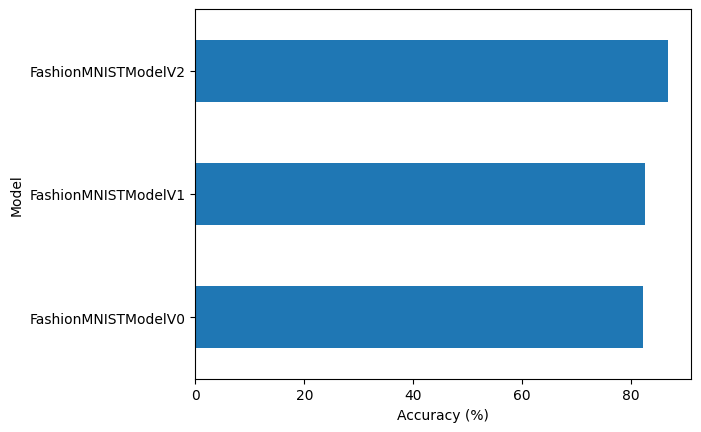

In [232]:
# Visualize our model results
compare_results.set_index("Model")["Accuracy"].plot(kind="barh")
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")

# Make and Evaluate Random Predictions with the Best Model

## Define Prediction Function

In [234]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = DEVICE):
    pred_probs = []
    model.eval()

    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            logits = model(sample)
            y_prob = torch.softmax(logits.squeeze(), dim=0)
            pred_probs.append(y_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

## Pick Random Samples For Prediction

In [238]:
random.seed(SEED)

test_samples = []
test_labels = []

class_names = train_data.classes

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print('Test Sample')
print('------------')
print(f'Image Shape: {test_samples[0].shape} Label: {test_labels[0]} ({class_names[test_labels[0]]})')

Test Sample
------------
Image Shape: torch.Size([1, 28, 28]) Label: 3 (Dress)


## Compute Class Probabilities

In [239]:
pred_probs= make_predictions(model=model_2, data=test_samples)

print('Sample Probabilities')
print('--------------------')
print(f'pred_probs[:2]: {pred_probs[:2]}')

Sample Probabilities
--------------------
pred_probs[:2]: tensor([[8.0484e-03, 9.8653e-04, 5.9769e-02, 6.9990e-01, 2.2732e-01, 8.1630e-05,
         2.7510e-03, 6.3744e-06, 1.1292e-03, 9.7403e-06],
        [3.9375e-04, 8.0394e-05, 3.1134e-02, 2.0991e-04, 8.9574e-01, 1.1387e-05,
         6.2479e-02, 3.3502e-06, 9.8985e-03, 5.4924e-05]])


## Predicted Classes

In [245]:
pred_classes = pred_probs.argmax(dim=1)

print('Predicted Classes')
print('-----------------')
print(f'pred_classes: {list(pred_classes.numpy())}')
print(f'test_labels : {test_labels}')

Predicted Classes
-----------------
pred_classes: [3, 4, 4, 3, 9, 4, 5, 8, 1]
test_labels : [3, 4, 4, 3, 5, 4, 5, 8, 1]


## Visualization

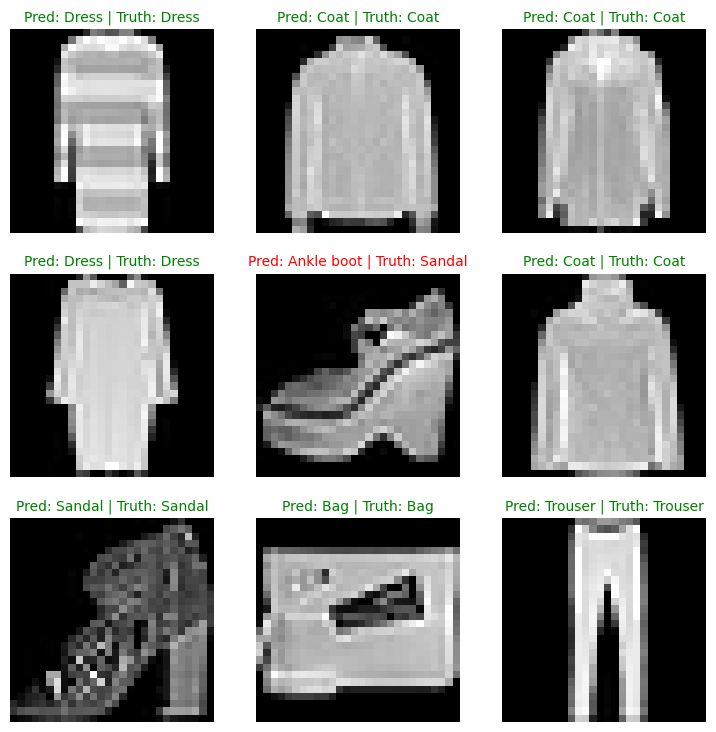

In [246]:
plt.figure(figsize=(9, 9))
rows, cols = 3, 3

for i, sample in enumerate(test_samples):
  plt.subplot(3, 3, i + 1)

  plt.imshow(sample.squeeze(), cmap="gray")

  # Extract Predicted and True Label Names
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]] 

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False)

# Make Confusion Matrix for Performance Evaluation

## Compute Predictions for the entire Test Dataset

In [250]:
y_preds = []
model_2.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        X, y = X.to(DEVICE), y.to(DEVICE)
        
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 313/313 [00:00<00:00, 358.39it/s]


## Compute Confusion Matrix

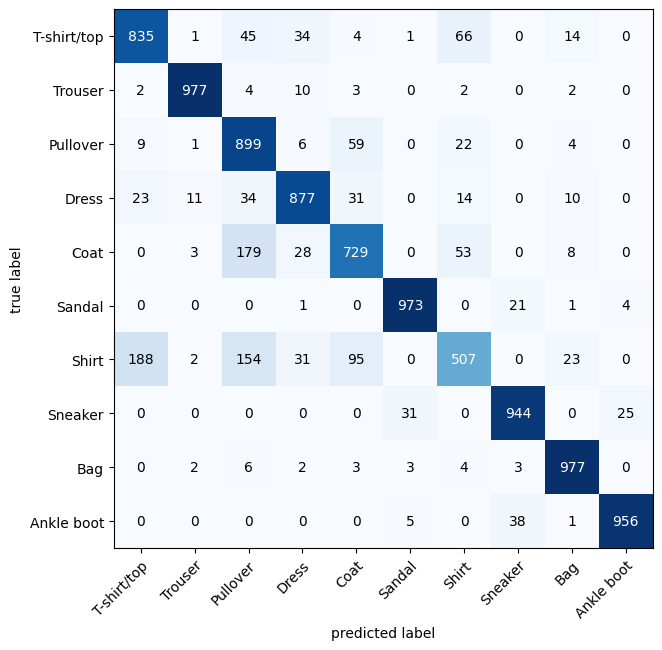

In [251]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

# Saving and Loading the Best Performing Model

In [253]:
### Saving a PyTorch Model ###
# 1. Create models store.
MODELS_STORE = Path("models")
MODELS_STORE.mkdir(parents=True, exist_ok=True)

# 2. Create model save path.
MODEL_NAME = "getting_started_with_vision_cnn.pth"
MODEL_SAVE_PATH = MODELS_STORE / MODEL_NAME

# 3. Save the model state dict
print('\nSaving a Model')
print('---------------')
print(f"Saving the model model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)
### Saving a PyTorch Model [ENDS] ###

### Loading a PyTorch Model ###
input_shape, hidden_units, output_shape = 1, 10, len(train_data.classes)
saved_model = FashionMNISTModelV2(input_shape, hidden_units, output_shape).to(DEVICE)

print('\nLoading a Saved Model')
print('------------------------')
print(f"Loading the model from: {MODEL_SAVE_PATH}")
saved_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH)) # Load the saved parameters


Saving a Model
---------------
Saving the model model to: models/getting_started_with_vision_cnn.pth

Loading a Saved Model
------------------------
Loading the model from: models/getting_started_with_vision_cnn.pth


<All keys matched successfully>